#  _dMasif for ADP binding site prediction_

Submission for the Geometric Deep Learning assesment, HT23.
Candidate Number: 1045801

This notebook contains a stand-alone implementation of the dMasif model for protein binding site prediction. 


In [ ]:
#@title Download dataset

# Perform these using a python kernel
!wget https://github.com/candidate1045801/gdl-mini-project/blob/main/data.zip
!unzip /content/data.zip
!rm /content/data.zip


## Julia notebook installation instructions
1. Copy to local drive
2. Change runtime type to use GPU acceleration
3. Execute the following cell to install the Julia kernel together with all the necessary packages. This may take a couple of minutes.
4. Reload this page and continue to the next section.


In [ ]:
# Credit for this code: https://github.com/ageron/julia_notebooks

# Assuming python3 runtime
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.8.1" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia"
JULIA_PACKAGES_IF_GPU="CUDA Flux OneHotArrays IJulia BenchmarkTools Logging LinearAlgebra Distributions Distances Distributed LogExpFunctions Random Plots BioStructures Bio3DView" 
# or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  nvidia-smi -L &> /dev/null && export GPU=1 || export GPU=0
  if [ $GPU -eq 1 ]; then
    JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia  

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Check the Installation' section."
fi

In [1]:
#@title Check the installation
display(versioninfo())
println()
try
    using CUDA
catch
    println("No GPU found.")
else
    run(`nvidia-smi`) 
end

nothing

Julia Version 1.8.1
Commit afb6c60d69 (2022-09-06 15:09 UTC)
Platform Info:
  OS: Windows (x86_64-w64-mingw32)
  CPU: 12 × Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-13.0.1 (ORCJIT, skylake)
  Threads: 4 on 12 virtual cores
Environment:
  JULIA_DEPOT_PATH = D:\Programs\julia_depot
  JULIA_NUM_THREADS = 4


Tue Apr 11 11:05:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 496.76       Driver Version: 496.76       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   47C    P8    N/A /  N/A |     75MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Process(`nvidia-smi`, ProcessExited(0))

In [2]:
# @title Import the required packages

# Machine Learning
using CUDA
using Flux
using OneHotArrays

using IJulia
using BenchmarkTools
using Logging
global_logger(ConsoleLogger())
using LinearAlgebra
using Distributions
using Distances
using Distributed
using LogExpFunctions: logsumexp as lsumexp

using Plots
using Random 
Random.seed!(1234);

# Part 1: Generate surface data from atom data

In [15]:
using BioStructures: resnameselector, collectresidues, coordarray, element, collectatoms,
                     read, PDB, StructuralElement, standardselector
                     
using Bio3DView
#@title Load input atom data

adpselector(res) = resnameselector(res, ["ADP"])
const ELEMENTS = ["C", "H", "N", "O", "S", "SE"]
const ELEMENT_IDS = Dict([(ELEMENTS[i], i) for i in eachindex(ELEMENTS)])
const RADII = [1.7, 1.1, 1.52, 1.55, 1.80, 1.90] # van der waals radii

function get_atom_data(struc::StructuralElement)
    aminoacids = collectresidues(struc, standardselector)
    coords = coordarray(aminoacids)

    types = get.(Ref(ELEMENT_IDS), element.(collectatoms(aminoacids); strip=true), 2)

    adps = collectresidues(struc, adpselector)
    adp_coords = coordarray(adps)

    # hack to be able to handle proteins which don't bind to ADP
    if isempty(adp_coords)
        adp_coords = [1e6, 1e6, 1e6]
    end
    return coords, types, adp_coords
end

struc = read("data/1BUP.pdb", PDB)
coords, types, adp_coords = get_atom_data(struc)
display(struc)

ProteinStructure 1BUP.pdb with 1 models, 1 chains (A), 378 residues, 3370 atoms

In [4]:
#@title Optimized sdf functions 
# low memory implementation of SDF
# to make faster - batch it up to enable parallelism
function sdf(x, coords, radii; ideal_dist = 1.05)
    a = coords
    vecs = similar(a)
    d = similar(a, 1, size(a, 2))
    v = similar(d)
    res = []
    for x_i in eachcol(x)
        vecs .= (x_i .- a).^2
        sum!(d, vecs)                               # d = sqdists(x_i, a)
        d .= .-sqrt.(d)                             # d = -dists(x_i, a)
        v .= d ./ radii'
        L = lsumexp(v)                              # L = logsumexp(-dists(x_i, a) / radii)
        d .= exp.(d)                                # d = exp.(-dists(x_i, a))
        σ = dot(d, radii') / sum(d)                 # σ = smoothed mean atom radius weighted by exp(-dists)
        push!(res, -σ*L)
    end
    return res .- ideal_dist
end


# memory heavy but correct
function heavy_sdf(x, coords, radii; ideal_dist = 1.05)
    sqdists = sum((reshape(x, 3, :, 1) .- reshape(coords, 3, 1, :)).^2; dims=1)
    dists = sqrt.(dropdims(sqdists; dims=1))
    expneg_dists= exp.(-dists)
    softavg_nbhrad = sum(expneg_dists .* radii'; dims=2) ./ sum(expneg_dists; dims=2)

    return vec(-softavg_nbhrad .* lsumexp(-dists ./ radii'; dims=2) .- ideal_dist)
end

#∇ₓSDF - low memory - to make faster should operate in bigger batches of columns over x
function grad_sdf(x, coords, radii)
    a = coords
    vecs = similar(a)
    d = similar(a, 1, size(a, 2)) # -dists
    ed = similar(d) # exp(-dists)
    nd = similar(d) # -dists(x_i, a) / radii (normalized dists by radius)
    grads = similar(x)

    for (i, x_i) in enumerate(eachcol(x))
        vecs .= (x_i .- a).^2
        sum!(d, vecs)                               # d = sqdists(x_i, a)
        d .= .-sqrt.(d)                             # d = -dists(x_i, a)
        nd .= d ./ radii'                           # nd = -dists(x_i, a) / radii
        ed .= exp.(d)                               # ed = exp(-dists)

        L = lsumexp(nd)                             # L = logsumexp(-dists(x_i, a)/radii)
        ϕ = sum(ed)
        ψ = dot(ed, radii')
        σ = ψ / ϕ

        # add σ*∇L
        vecs .= exp.(nd)  ./ (d .* radii') .* (x_i .- a)
        @views grads[:, i] .= -σ * sum(vecs;dims=2) / exp(L)

        # add ∇ϕ component
        vecs .= (ed ./ d) .* (x_i .- a) # ∇ϕ component
        @views grads[:, i] .-= -ψ * L * sum(vecs;dims=2) / ϕ^2

        # add ∇ψ component
        vecs .*= radii' # ∇ψ component
        @views grads[:, i] .-= ϕ * L * sum(vecs;dims=2) / ϕ^2
    end

    return grads
end

# Profiling and correctness checks 
function check_sdf()
    xx = rand(3, 4000)
    c = rand(3, 2000)
    r = rand(2000)

    println("My sdf")
    @time sdf(xx, c, r)
    println("Heavy sdf")
    @time heavy_sdf(xx, c, r)

    @assert isapprox(sdf(xx, c, r), heavy_sdf(xx, c, r))

    msd(x) = sum(heavy_sdf(x, c, r))
    println("My grad")
    @time grad_sdf(xx, c, r)
    println("Heavy grad")
    @time gradient(msd, xx)[1]

    @assert isapprox(grad_sdf(xx, c, r), gradient(msd, xx)[1])
end
#check_sdf()

check_sdf (generic function with 1 method)

In [29]:
function sample_surface(coords, radii; 
                        samples_per_atom=1, num_iters=10, step_size=2.0, error_margin=0.3,
                        batch_size=2000)
    A = size(coords, 2)
    B = samples_per_atom

    mysdf(p) = sdf(p, coords, radii)
    mygrad_sdf(p) = grad_sdf(p, coords, radii)

    # Step 1 - Sample point cloud around atoms
    @info "initial #samples " * string(A*B)
    x = rand(Normal(0.0, 1.0), 3, A, B) 
    x .= x .* radii' .+ coords
    x = reshape(x, 3, :) # size(x) = (3, A*B)

    # Step 2 - Bring points closer to surface by minimizing the squared sdf
    #          via gradient descent
    @info "Attracting samples to surface via gradient descent"
    batches = collect(Iterators.partition(axes(x, 2), batch_size))
    for i in 1:num_iters
        #n.b. this could be done on the gpu and would be much faster
        Threads.@threads for cols in batches
            @views x_batch = x[:, cols]
            x_batch .-= step_size .* mysdf(x_batch)' .* mygrad_sdf(x_batch) # grad(mse(sdf))
        end
        @info "Loss at iter $i: " * string(mean(mysdf(x).^2) / 2)
    end

    # Step 3 - Clean the samples

    # Discard samples far away from the surface
    mask = abs.(mysdf(x)) .< error_margin
    x = x[:, mask]
    @info "#samples left after distance cull: " * string(count(mask))

    # Compute normals as gradient of surface implicit function (aka sdf)
    normals = mygrad_sdf(x)
    foreach(normalize!, eachcol(normals))

    # Discard samples nested inside the protein 
    # i.e. if moving "upwards" by 4Å actually reduces the distance to the surface
    mask = (mysdf(x .+ 4 .* normals) .- mysdf(x)) .> 0.5
    x = x[:, mask]
    normals = normals[:, mask]
    @info "#samples left after trapped cull: " * string(count(mask))

    # Step 4 - subsampling - make sure sampling was uniform in space
    # For each cubic bin of size 0.5Å we keep one sample per cell

    # technically this is not subsampling because it is deterministic and always chooses 
    # one point per grid; might give slightly biased results
    grid_loc = floor.(Int, x)
    unique_idx = unique(i -> grid_loc[:, i], 1:size(x, 2))
    x = x[:, unique_idx]
    normals = normals[:, unique_idx]
    @info "#samples left after subsampling: " * string(length(unique_idx))

    return x, normals
end

radii = RADII[types]
x, normals = sample_surface(coords, radii);

[ Info: initial #samples 2902
[ Info: Attracting samples to surface via gradient descent


[ Info: Loss at iter 1: 4.644603522396194


[ Info: Loss at iter 2: 3.5681958022819433


[ Info: Loss at iter 3: 2.9166895131995743


[ Info: Loss at iter 4: 2.496005458956401


[ Info: Loss at iter 5: 2.2016636258863422


[ Info: Loss at iter 6: 1.9854838354822035


[ Info: Loss at iter 7: 1.8204507699420793


[ Info: Loss at iter 8: 1.6961221209480741


[ Info: Loss at iter 9: 1.609209678465808


[ Info: Loss at iter 10: 1.54588201288862


[ Info: #samples left after distance cull: 1973
[ Info: #samples left after trapped cull: 1973
[ Info: #samples left after subsampling: 1470


In [31]:
# Returns for each x_i in x the indices of the kth nearest points in coords and the 
# distances to them
function knearest(x, coords; k=16)
    vecs = similar(coords)
    sqdists = similar(coords, size(coords, 2))
    ids = Array{Integer}(undef, k, size(x, 2))
    dists = similar(x, k, size(x, 2))
    # hot loop
    for (i, x_i) in enumerate(eachcol(x))
        vecs .= (x_i .- coords).^2
        sqdists .= dropdims(sum(vecs; dims=1);dims=1)                             
        @views ids[:, i] .= sortperm(sqdists; alg=PartialQuickSort(k))[1:k]
        @views dists[:, i] .= sqrt.(sqdists[ids[:, i]])
    end
    return ids, dists
end

nbh_atom_ids, dists = knearest(x, coords; k=8)

t = reshape(types[vec(nbh_atom_ids)], size(nbh_atom_ids))
t_onehot = onehotbatch(t, 1:6, 2)
inv_dists = 1 ./ dists # size = 16 x num_samples

labels = knearest(x, adp_coords; k=1)[2] .< 10.0

count(labels)

40

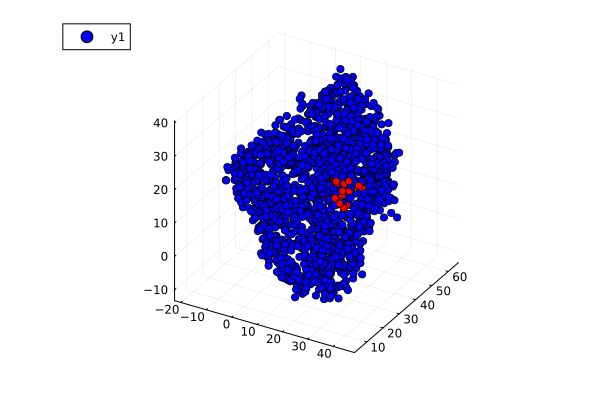

In [28]:
#@title Plot the resulting surface
using Plots 

colours = fill("blue", size(labels))
colours[labels] .= "red"
scatter(x[1,:], x[2,:],x[3,:], color=vec(colours))

In [32]:
#@Geodesic distance utils

function dists_dots(x, n, nbh_ids)
    k = size(nbh_ids, 1)
    vecs = similar(x, 3, k)
    v = similar(x, k)
    dists = similar(x, k, size(x, 2))
    dots = similar(dists)
    # hot loop
    for i in axes(x, 2)
        @views x_i = x[:, i]; n_i = n[:, i]
        vecs .= (x_i .- x[:, nbh_ids[:, i]]).^2
        v .= dropdims(sum(vecs; dims=1);dims=1)                             
        @views dists[:, i] .= sqrt.(v)

        vecs .= (n_i .* n[:, nbh_ids[:, i]])
        v .= dropdims(sum(vecs; dims=1);dims=1)  
        @views dots[:, i] .= v
    end
    return dists, dots
end

function quasi_geodesic_dist(x, n, nbh_ids; λ=1)
    dists, dots = dists_dots(x, n, nbh_ids)

    return dists .* (1 .+ λ .* (1 .- dots))
end

function my_geodesic_dist(x, n, nbh_ids)
    dists, dots = dists_dots(x, n, nbh_ids)
    clamp!(dots, -1.0+1e-14, 1.0-1e-14)
    return dists .* acos.(dots) ./ sqrt.(2 .- 2 .* dots)
end

# Process dists so that they can be used inside the gaussian filter
function gaussian_filter!(dists; σ=9)
    dists .= exp.(.-dists.^2 ./ (2 .* σ^2))
    return dists
end

nbh_ids, dists = knearest(x, x; k=100);

In [33]:
#@title 3D geometry methods

# Generate arbitrary local reference frames for each normal
function nuv_from_n(n)
    @views x = n[1, :]; y = n[2, :]; z = n[3, :]
    s = sign.(z)
    a = -1.0 ./ (s .+ z)
    b = a .* x .* y

    u = similar(n)
    u[1, :] .= 1 .+ s .* a .* x .* x 
    u[2, :] .= s .* b 
    u[3, :] .= .- s .* x 

    v = similar(n)
    v[1, :] .= b 
    v[2, :] .= s .+ a .* y .* y 
    v[3, :] .= .-y

    nuv = cat(reshape(n, 3, 1, :) , reshape(u, 3, 1, :), reshape(v,3, 1,:); dims=2)
    # size nuv = (3, 3, num_samples)
    return nuv
end

# Compute positions of neighbours w.r.t local reference frames
function local_pos(pos, frame, nbh_ids)
    # size(frame, 1) = 3
    k = size(frame, 2) # ∈ [1, 2, 3]
    @views res = map(i -> frame[:, :, i]' * (pos[:, nbh_ids[:, i]] .- pos[:, i]),axes(pos, 2))
    # size res[i] = (k, 3) * (3, nbh_size) = (k, nbh_size)

    # for i in axes(x, 2)
    #     @views x_i = x[:, i]
    #     @views local_frame = nuv[:, :, i]
    #     @views x_j = x[:, nbh_ids[:, i]]
    #     push!(res, local_frame' * (x_j .- x_i)) # (3, 3) * (3, nbh_size) = (3, nbh_size)
    # end

    # final size: (k, nbh_size, num_samples)
    return reshape(cat(res...;dims=2), k, size(nbh_ids, 1), size(pos, 2))
end

nuv = nuv_from_n(normals)
local_pos(x, nuv, nbh_ids);

In [34]:
#@title Putting it all together
function process_data_from_pdb(id::String; 
                               atom_nbh_size=8, ligand_bind_range=3.0)
    struc = read("data/" * id * ".pdb", PDB)
    atom_coords, atom_types, adp_coords = get_atom_data(struc)
    atom_radii = RADII[atom_types]

    # Sample oriented point cloud surface from atom metaball 
    pos, normals = sample_surface(atom_coords, atom_radii; num_iters=10)
    nbh_atom_ids, atom_dists = knearest(pos, atom_coords; k=atom_nbh_size)

    sample_types = reshape(atom_types[vec(nbh_atom_ids)], size(nbh_atom_ids))
    types_onehot = onehotbatch(sample_types, 1:6, 2) 
    inv_dists = 1 ./ atom_dists # atom_nbh_size x num_samples

    # 7 x atom_nbh_size x num_samples
    feats = cat(types_onehot, reshape(inv_dists, 1, atom_nbh_size, :) ;dims=1)

    labels = knearest(pos, adp_coords; k=1)[2] .< ligand_bind_range

    # For tractability reasons, only convolve over the closest k samples w.r.t L2 distance
    #nbh_surface_ids, _ = knearest(x, x; k=surface_nbh_size=300)
    #weights = geodesic_dist(x, n, nbh_surface_ids)
    #gaussian_filter!(weights)

    return (pos=pos, normals=normals, feats=feats, labels=labels)
end

@time data = process_data_from_pdb("1AE4");

[ Info: initial #samples 324
[ Info: Attracting samples to surface via gradient descent
[ Info: Loss at iter 1: 0.19881406657373274
[ Info: Loss at iter 2: 0.14260906726778114
[ Info: Loss at iter 3: 0.10725823434441158
[ Info: Loss at iter 4: 0.08253523184207223


[ Info: Loss at iter 5: 0.06501586971837849
[ Info: Loss at iter 6: 0.052467662307174916
[ Info: Loss at iter 7: 0.043338491298885756
[ Info: Loss at iter 8: 0.036431948403982166
[ Info: Loss at iter 9: 0.030946531996618815
[ Info: Loss at iter 10: 0.026454111141878928


[ Info: #samples left after distance cull: 279
[ Info: #samples left after trapped cull: 207


  0.860487 seconds (2.28 M allocations: 114.546 MiB, 4.86% gc time, 73.02% compilation time)


[ Info: #samples left after subsampling: 206


# Part 2: Learning over the protein surface data

In [36]:
#@title Chemical Layer - compute chemical embedding of points based on surrounding atoms 

struct ChemicalLayer
    atomMLP::Chain
    sampleMLP::Chain
end 
function ChemicalLayer(;input_dim=7, num_atoms=8, hidden_dim=12, emb_dim=6)
    atomMLP = Chain(Dense(input_dim => hidden_dim),
                    BatchNorm(num_atoms, leakyrelu),
                    Dense(hidden_dim => emb_dim))
    sampleMLP = Chain(Dense(emb_dim => hidden_dim),
                      BatchNorm(hidden_dim, leakyrelu),
                      Dense(hidden_dim => emb_dim))
    return ChemicalLayer(atomMLP, sampleMLP)
end
function(m::ChemicalLayer)(x)
    # Embed atoms in chemical space using an MLP
    x = m.atomMLP(x)
    # Aggregate for each sample, using a second MLP
    x = dropdims(sum(x; dims=2);dims=2)
    return m.sampleMLP(x)
end

Flux.@functor ChemicalLayer
model = ChemicalLayer() |> gpu
chem_emb = model(Float32.(data[:feats]) |> gpu) |> cpu

6×206 Matrix{Float32}:
 -0.593323   -0.594025   -0.597511   …  -0.596568   -0.599103   -0.595847
  0.0305562   0.0312665   0.0302186      0.0313445   0.0334173   0.0309054
  0.0459963   0.0465455   0.046073       0.044523    0.0428983   0.0478436
 -0.219877   -0.219837   -0.222499      -0.221258   -0.221831   -0.221158
  0.301853    0.302501    0.305088       0.303432    0.304691    0.304615
 -0.896682   -0.897639   -0.904422   …  -0.901288   -0.903999   -0.901726

In [37]:
# Scalar field over protein surface
# Projecting its gradient onto the tangent plane yields a smooth vector field 
# This ensures that the gauge of the manifold is smooth and consistent which is important,
# because the convolution of the signal depends on the specific coordinate choice
struct PotentialLayer
    chain::Chain
end 
function PotentialLayer(;input_dim=6, hidden_dim=16)
    chain = Chain(Dense(input_dim => hidden_dim),
                  BatchNorm(hidden_dim, leakyrelu),
                  Dense(hidden_dim => hidden_dim),
                  BatchNorm(hidden_dim, leakyrelu),
                  Dense(hidden_dim => 1))
    return PotentialLayer(chain)
end
function(m::PotentialLayer)(x)
    return m.chain(x)
end
Flux.@functor PotentialLayer

potmodel = PotentialLayer() |> gpu 
pot = potmodel(chem_emb |> gpu) |> cpu

1×206 Matrix{Float32}:
 0.167051  0.167252  0.168433  0.167966  …  0.167978  0.168648  0.167933

In [38]:
struct ConvLayer
    local_mlp::Chain
end

function ConvLayer()
    local_mlp = Chain(Dense(6 => 16),
                             BatchNorm(16, leakyrelu),
                             Dense(16 => 1))
    return ConvLayer(local_mlp)
end

function (m::ConvLayer)(emb, window, p_ij, nbh_ids)
    @views emb_ij = cat(map(i -> emb[:, nbh_ids[:, i]], axes(emb, 2))...;dims=2)
    p_ij_uv = local_pos(pos, uv, nbh_ids)
    out = dropdims(sum(window .* m.localMLP(p_ij) .* emb_ij; dims=2);dims=2)
    return out
end
Flux.@functor ConvLayer

In [40]:
function update_nuv(potentials, pos, nuv, nbh_ids, window)
    num_samples = size(pos, 2)

    window = reshape(window, 1, size(window)...)
    # size window = (1, nbh_size, num_samples)

    #pots_ij = p_j - p_i 
    # i.e. change of potential when going from i to j 
    ps = potentials
    @views pots_ij = cat(map(i -> ps[:, nbh_ids[:, i]] .- ps[:, i], axes(pos, 2))...;dims=2)
    pots_ij = reshape(pots_ij, 1, :, num_samples)
    # size pots_ij = (1, nbh_size, num_samples)

    #p_ij_uv gives location of pos_j w.r.t. the tangent plane of point i 
    @views p_ij_uv = local_pos(pos, nuv[:, 2:3, :], nbh_ids)
    # size p_ij_uv = (2, nbh_size, num_samples)

    # new_u sits in the (u,v) plane
    new_u = dropdims(mean(window .* pots_ij .* p_ij_uv; dims=2);dims=2)
    # size new_u = (2, num_samples)
    # bring new_u to 3D => size = (3, num_samples)
    new_u = vcat(zeros(Float32, 1, num_samples), new_u)

    # rotate u counter clockwise by 90 degrees to get v
    # rot by 90deg: (x, y) -> (-y, x)
    @views new_v = vcat(zeros(Float32, 1, num_samples), -new_u[2, :]', new_u[1, :]')

    new_uv = cat(reshape(new_u, 3, 1, :), reshape(new_v, 3, 1, :); dims=2)
    # Finally, rotate new_u, new_v so that their normals match 
    # This amounts to reversing the local frame transformation
    @views new_uv = map(i -> inv(nuv[:, :, i])' * new_uv[:, :, i],axes(pos, 2))
    new_uv = reshape(cat(new_uv...;dims=2), 3, 2, num_samples)

    @views n = reshape(nuv[:, 1, :], 3, 1, :)
    new_nuv = cat(n, new_uv; dims=2)

    return new_nuv
end

update_nuv (generic function with 1 method)

In [42]:
struct DMasif
    chem_layer::ChemicalLayer
    potential_layer::PotentialLayer
    classifier_layer::Chain
    conv_layer::ConvLayer
end

function DMasif()
    chem_layer = ChemicalLayer()
    potential_layer = PotentialLayer()
    classifier_layer = Chain(Dense(6 => 16),
                             BatchNorm(16, leakyrelu),
                             Dense(16 => 1))
    conv_layer = ConvLayer()
    return DMasif(chem_layer, potential_layer, classifier_layer, conv_layer)
end


function (m::DMasif)(pos, nuv, feats, nbh_ids, window)
    # Compute embedding based on chemical properties
    emb = m.chem_layer(feats)

    # Update gauge based on gradient of potential
    potentials = m.potential_layer(emb)
    nuv = update_nuv(potentials, pos, nuv, nbh_ids, window)
    
    # Apply several quasi-geodesic convolutions to update embedding
    p_ij = local_pos(pos, nuv, nbh_ids)

    emb = m.conv_layer(emb, window, p_ij, nbh_ids)

    # Finally, classify point based on its embedding
    out = m.classifier_layer(emb)
    return out 
end
Flux.@functor DMasif

pos = data[:pos] 
nuv = nuv_from_n(data[:normals])
feats = data[:feats]
nbh_ids = copy(knearest(pos, pos; k=100)[1])
window = quasi_geodesic_dist(pos, data[:normals], nbh_ids)
gaussian_filter!(window)

model = DMasif()
affinity = model(pos, nuv, feats, nbh_ids, window) 


ErrorException: invalid redefinition of constant DMasif